In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.6.0'

#### Load Bilinear Loading Dataset (https://zenodo.org/records/7915753) :

In [4]:
all_features = np.load("Bilinear_Loading_Dataset/Features.npy")
all_neck = np.load("Bilinear_Loading_Dataset/Necks.npy")
print(all_neck.shape)

#split
X_train, X_test, y_train, y_test = train_test_split(all_features, all_neck, test_size=0.15, random_state=42)

def convert(X):
    return 1 - np.exp(-X)

def convert_inverse(K):
    return -np.log(1-K)

normalized_y_train = convert(y_train)

(19098, 401)


#### Convolutional Blocks :

In [5]:
class GLU(layers.Layer):
    def __init__(self, dim=-1):
        super(GLU, self).__init__()
        self.dim = dim

    def call(self, x):
        out, gate = tf.split(x, num_or_size_splits=2, axis=self.dim)
        gate = tf.sigmoid(gate)
        x = tf.multiply(out, gate)
        return x

In [6]:
class CNN_block(layers.Layer):
    def __init__(self, embed_dim, hid_dim, kernel_size, num_layers):
        super().__init__()
        
        self.embed_hidden = tf.keras.layers.Dense(hid_dim, activation = 'tanh')
        self.convs = [tf.keras.layers.Conv1D(filters = 2*hid_dim, kernel_size = kernel_size, activation='tanh', padding = "same") for _ in range(num_layers)]
        self.glu = GLU(dim = 2)
        self.add = tf.keras.layers.Add()
        self.hidden_embed = tf.keras.layers.Dense(embed_dim)

    def call(self, inputs):

        conv_input = self.embed_hidden(inputs)

        for conv in self.convs:

          #pass through convolutional layer
          conved = conv(conv_input)

          #pass through GLU activation function
          conved = self.glu(conved)

          #apply residual connection
          conved = self.add([conved, conv_input])
            
          #set conv_input to conved for next loop iteration
          conv_input = conved

        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hidden_embed(conv_input)

        output = self.add([inputs, conved])

        return output

In [7]:
def build(num_blocks, number_of_layers): 

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(None,3)))

    for i in range(num_blocks):

        model.add(CNN_block(embed_dim = 3, hid_dim = 3, kernel_size = 6, num_layers = number_of_layers))
  
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

    model.add(tf.keras.layers.Flatten())

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

    return model

In [8]:
# Number of blocs 1-5
# Number of layers 1-80

NB = [i for i in range(1,6)]
NL = [i for i in range(1,81,2)]

In [9]:
Training_Results = []

C = 0

for num_blocks in NB:
    
    for num_layers in NL:
        
        MODEL = build(num_blocks, num_layers)
        number_of_parameters = MODEL.count_params()
            
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
                
            MODEL.fit(X_train, normalized_y_train, epochs=100, validation_split=0.1, verbose=0, batch_size=64)
                
            end = time.time()
                
            y_pred_neural = convert_inverse(MODEL.predict(X_test))
            y_pred_train = convert_inverse(MODEL.predict(X_train))
                
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test,y_pred_neural)
                
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [num_layers, num_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))

 1 -- Train results, Train mse : 0.012277 Test mse: 0.012035, number of parameters : 142, time passed : 81.489970
 2 -- Train results, Train mse : 0.009871 Test mse: 0.009671, number of parameters : 370, time passed : 112.263808
 3 -- Train results, Train mse : 0.008391 Test mse: 0.008275, number of parameters : 598, time passed : 143.183604
 4 -- Train results, Train mse : 0.006805 Test mse: 0.006673, number of parameters : 826, time passed : 173.845312
 5 -- Train results, Train mse : 0.006659 Test mse: 0.006189, number of parameters : 1054, time passed : 206.946115
 6 -- Train results, Train mse : 0.005588 Test mse: 0.005445, number of parameters : 1282, time passed : 240.091054
 7 -- Train results, Train mse : 0.005901 Test mse: 0.005544, number of parameters : 1510, time passed : 271.846095
 8 -- Train results, Train mse : 0.005664 Test mse: 0.005299, number of parameters : 1738, time passed : 300.817126
 9 -- Train results, Train mse : 0.006377 Test mse: 0.005989, number of param

 31 -- Train results, Train mse : 0.004174 Test mse: 0.003933, number of parameters : 6982, time passed : 1028.590329
 32 -- Train results, Train mse : 0.004543 Test mse: 0.004229, number of parameters : 7210, time passed : 1058.188397
 33 -- Train results, Train mse : 0.005110 Test mse: 0.004953, number of parameters : 7438, time passed : 1090.536016
 34 -- Train results, Train mse : 0.004487 Test mse: 0.004179, number of parameters : 7666, time passed : 1124.249777
 35 -- Train results, Train mse : 0.004558 Test mse: 0.004176, number of parameters : 7894, time passed : 1156.571308
 36 -- Train results, Train mse : 0.004056 Test mse: 0.003827, number of parameters : 8122, time passed : 1186.928260
 37 -- Train results, Train mse : 0.004622 Test mse: 0.004343, number of parameters : 8350, time passed : 1219.582850
 38 -- Train results, Train mse : 0.004647 Test mse: 0.004508, number of parameters : 8578, time passed : 1252.668446
 39 -- Train results, Train mse : 0.006170 Test mse: 0.0

 61 -- Train results, Train mse : 0.004129 Test mse: 0.003986, number of parameters : 9400, time passed : 1386.364163
 62 -- Train results, Train mse : 0.004235 Test mse: 0.003938, number of parameters : 9856, time passed : 1451.272266
 63 -- Train results, Train mse : 0.011068 Test mse: 0.010958, number of parameters : 418, time passed : 168.309395
 64 -- Train results, Train mse : 0.006775 Test mse: 0.006538, number of parameters : 1102, time passed : 260.681854
 65 -- Train results, Train mse : 0.006107 Test mse: 0.005653, number of parameters : 1786, time passed : 356.822132
 66 -- Train results, Train mse : 0.006570 Test mse: 0.006023, number of parameters : 2470, time passed : 452.025204
 67 -- Train results, Train mse : 0.005723 Test mse: 0.005512, number of parameters : 3154, time passed : 546.891745
 68 -- Train results, Train mse : 0.005168 Test mse: 0.004987, number of parameters : 3838, time passed : 643.866239
 69 -- Train results, Train mse : 0.004782 Test mse: 0.004544, 

 78 -- Train results, Train mse : 0.006899 Test mse: 0.006688, number of parameters : 556, time passed : 209.742793
 79 -- Train results, Train mse : 0.006612 Test mse: 0.006381, number of parameters : 1468, time passed : 335.832707
 80 -- Train results, Train mse : 0.004953 Test mse: 0.004756, number of parameters : 2380, time passed : 465.241155
 81 -- Train results, Train mse : 0.005695 Test mse: 0.005363, number of parameters : 3292, time passed : 591.472038
 82 -- Train results, Train mse : 0.004554 Test mse: 0.004421, number of parameters : 4204, time passed : 719.263059
 83 -- Train results, Train mse : 0.004607 Test mse: 0.004381, number of parameters : 5116, time passed : 846.827941
 84 -- Train results, Train mse : 0.005137 Test mse: 0.004938, number of parameters : 6028, time passed : 976.485569
 85 -- Train results, Train mse : 0.005592 Test mse: 0.005422, number of parameters : 6940, time passed : 1098.470430
 86 -- Train results, Train mse : 0.005101 Test mse: 0.005006, n

 89 -- Train results, Train mse : 0.008185 Test mse: 0.008065, number of parameters : 694, time passed : 279.706884
 90 -- Train results, Train mse : 0.007391 Test mse: 0.007299, number of parameters : 1834, time passed : 442.283321
 91 -- Train results, Train mse : 0.005462 Test mse: 0.005358, number of parameters : 2974, time passed : 607.611460
 92 -- Train results, Train mse : 0.004849 Test mse: 0.004648, number of parameters : 4114, time passed : 769.967516
 93 -- Train results, Train mse : 0.005496 Test mse: 0.005286, number of parameters : 5254, time passed : 935.515139
 94 -- Train results, Train mse : 0.005304 Test mse: 0.005072, number of parameters : 6394, time passed : 1098.162719
 95 -- Train results, Train mse : 0.005563 Test mse: 0.005531, number of parameters : 7534, time passed : 1261.145510
 96 -- Train results, Train mse : 0.004288 Test mse: 0.004056, number of parameters : 8674, time passed : 1429.904163
 97 -- Train results, Train mse : 0.003905 Test mse: 0.003791,

##### Save the training results ... 

In [10]:
with open("CNN_RNN_Transformers_Training_Results/CNN_blocks_0_10000_TensorFlow.json", 'w') as f:
    json.dump(Training_Results, f)
    
f = open("CNN_RNN_Transformers_Training_Results/CNN_blocks_0_10000_TensorFlow.json")
data = json.load(f)

##### Plot the overall results based on Mean Squared Error and changing number of parameters in the NN archtiectures

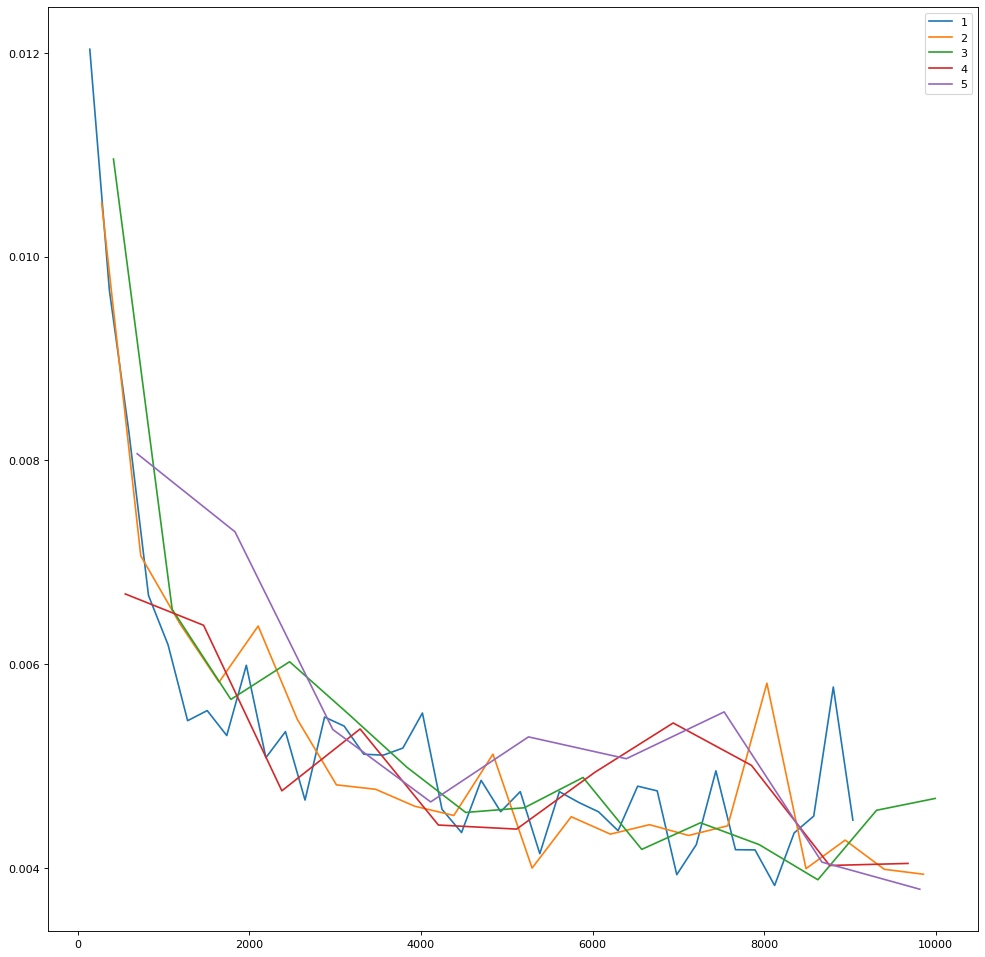

In [11]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

### RNN

* We conducted experiments with both Gated Recurrent Unit (GRU) and Long Short Term Memory (LSTM) layers.

#### LSTM Blocks :

In [12]:
class RNN_block(layers.Layer):
    def __init__(self, units=32):
        super().__init__()

        self.lstm_1 = tf.keras.layers.LSTM(units, return_sequences = True, return_state = True)
        self.lstm_2 = tf.keras.layers.LSTM(units, return_sequences=True)

    def call(self, inputs):

        lstm_1_output, state_h_1, state_c_1 = self.lstm_1(inputs)

        encoder_state = [state_h_1, state_c_1]

        output = self.lstm_2(lstm_1_output, initial_state = encoder_state)

        return output

In [13]:
def build(blocks, units): 

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(None,3)))

    for i in range(blocks):

        model.add(RNN_block(units))
  
    model.add(RNN_block(1))

    model.add(tf.keras.layers.Flatten())

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

    return model

In [14]:
# Number of blocks 1-5
# Number of units 1-28

NB = [1,2,3,4,5] # Number of blocks
U = [i for i in range(1,29,1)] # Hidden units

In [15]:
C = 0

Training_Results = []

for units in U:
  
    for blocks in NB:
        
        MODEL = build(blocks, units)
        number_of_parameters = MODEL.count_params()
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
                
            MODEL.fit(X_train, normalized_y_train, epochs=100, validation_split=0.1, verbose=0, batch_size=64)
                
            end = time.time()
                
            y_pred_neural = convert_inverse(MODEL.predict(X_test))
            y_pred_train = convert_inverse(MODEL.predict(X_train))
                
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test,y_pred_neural)
                
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [units, blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
        


 1 -- Train results, Train mse : 0.015026 Test mse: 0.014910, number of parameters : 56, time passed : 1237.922484
 2 -- Train results, Train mse : 0.014916 Test mse: 0.014608, number of parameters : 80, time passed : 2192.290324
 3 -- Train results, Train mse : 0.010689 Test mse: 0.010416, number of parameters : 104, time passed : 3148.222785
 4 -- Train results, Train mse : 0.010523 Test mse: 0.010267, number of parameters : 128, time passed : 4101.883977
 5 -- Train results, Train mse : 0.014681 Test mse: 0.014585, number of parameters : 152, time passed : 5044.121839
 6 -- Train results, Train mse : 0.007432 Test mse: 0.007103, number of parameters : 116, time passed : 1267.511595
 7 -- Train results, Train mse : 0.005165 Test mse: 0.004933, number of parameters : 196, time passed : 2286.299446
 8 -- Train results, Train mse : 0.006709 Test mse: 0.006461, number of parameters : 276, time passed : 3307.987189
 9 -- Train results, Train mse : 0.005757 Test mse: 0.005588, number of pa

 31 -- Train results, Train mse : 0.003246 Test mse: 0.003260, number of parameters : 776, time passed : 1212.639302
 32 -- Train results, Train mse : 0.003069 Test mse: 0.002983, number of parameters : 1616, time passed : 2142.062076
 33 -- Train results, Train mse : 0.002276 Test mse: 0.002239, number of parameters : 2456, time passed : 3011.605385
 34 -- Train results, Train mse : 0.001561 Test mse: 0.001628, number of parameters : 3296, time passed : 3875.086022
 35 -- Train results, Train mse : 0.001638 Test mse: 0.001572, number of parameters : 4136, time passed : 4660.245167
 36 -- Train results, Train mse : 0.004548 Test mse: 0.004356, number of parameters : 980, time passed : 1165.189249
 37 -- Train results, Train mse : 0.001867 Test mse: 0.001790, number of parameters : 2068, time passed : 2085.242919
 38 -- Train results, Train mse : 0.001935 Test mse: 0.001876, number of parameters : 3156, time passed : 2922.525570
 39 -- Train results, Train mse : 0.002727 Test mse: 0.002

 60 -- Train results, Train mse : 0.003676 Test mse: 0.003561, number of parameters : 2360, time passed : 1321.163629
 61 -- Train results, Train mse : 0.001023 Test mse: 0.001055, number of parameters : 5168, time passed : 2337.184383
 62 -- Train results, Train mse : 0.001322 Test mse: 0.001309, number of parameters : 7976, time passed : 3346.179578
 63 -- Train results, Train mse : 0.002058 Test mse: 0.002034, number of parameters : 2708, time passed : 1317.051322
 64 -- Train results, Train mse : 0.001746 Test mse: 0.001765, number of parameters : 5956, time passed : 2342.744354
 65 -- Train results, Train mse : 0.003816 Test mse: 0.003649, number of parameters : 9204, time passed : 3324.428986
 66 -- Train results, Train mse : 0.002609 Test mse: 0.002456, number of parameters : 3080, time passed : 1339.232337
 67 -- Train results, Train mse : 0.001256 Test mse: 0.001281, number of parameters : 6800, time passed : 2361.774627
 68 -- Train results, Train mse : 0.001886 Test mse: 0.0

 76 -- Train results, Train mse : 0.001562 Test mse: 0.001510, number of parameters : 5816, time passed : 1344.515755
 77 -- Train results, Train mse : 0.003578 Test mse: 0.003396, number of parameters : 6356, time passed : 1332.748044
 78 -- Train results, Train mse : 0.001093 Test mse: 0.001135, number of parameters : 6920, time passed : 1344.105773
 79 -- Train results, Train mse : 0.001769 Test mse: 0.001739, number of parameters : 7508, time passed : 1205.678450
 80 -- Train results, Train mse : 0.000923 Test mse: 0.000936, number of parameters : 8120, time passed : 1353.762943
 81 -- Train results, Train mse : 0.001345 Test mse: 0.001428, number of parameters : 8756, time passed : 1350.980767
 82 -- Train results, Train mse : 0.001501 Test mse: 0.001405, number of parameters : 9416, time passed : 1352.113616


##### Save the training results ... 

In [16]:
with open("CNN_RNN_Transformers_Training_Results/LSTM_blocks_0_10000_TensorFlow.json", 'w') as f:
    json.dump(Training_Results, f)
    
f = open("CNN_RNN_Transformers_Training_Results/LSTM_blocks_0_10000_TensorFlow.json")
data = json.load(f)

##### Plot the overall results based on Mean Squared Error and changing number of parameters in the NN archtiectures

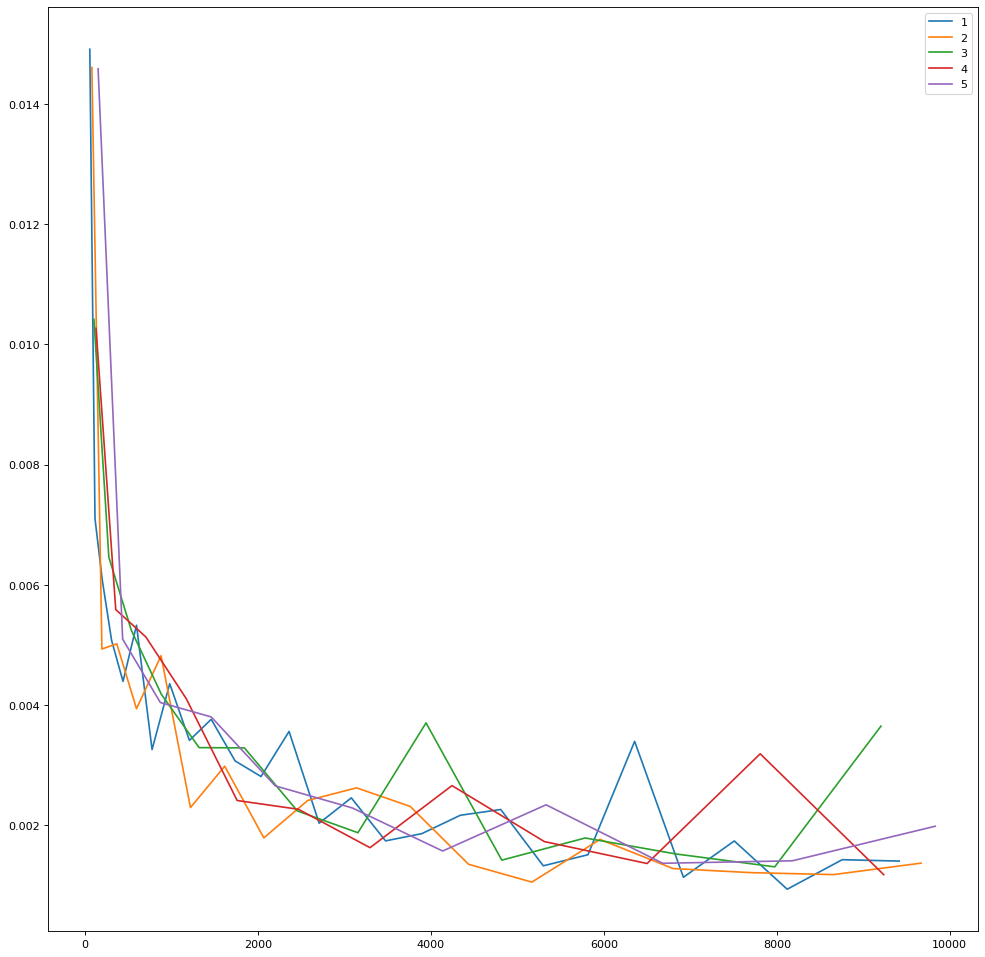

In [17]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

#### GRU Blocks :

In [18]:
class RNN_block(layers.Layer):
    def __init__(self, units=32):
        super().__init__()

        self.gru_1 = tf.keras.layers.GRU(units, return_sequences = True, return_state = True)
        self.gru_2 = tf.keras.layers.GRU(units, return_sequences=True)

    def call(self, inputs):

        gru_1_output, encoder_state = self.gru_1(inputs)

        output = self.gru_2(gru_1_output, initial_state = encoder_state)

        return output

In [19]:
def build(blocks, units): 

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(None,3)))

    for i in range(blocks):

        model.add(RNN_block(units))
  
    model.add(RNN_block(1))

    model.add(tf.keras.layers.Flatten())

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

    return model

In [20]:
# Number of blocks 1-5
# Number of units 1-28

NB = [1,2,3,4,5] # Number of blocks
U = [i for i in range(1,29,1)] # Hidden units

In [21]:
C = 0

Training_Results = []

for units in U:
  
    for blocks in NB:
        
        MODEL = build(blocks, units)
        number_of_parameters = MODEL.count_params()
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
                
            MODEL.fit(X_train, normalized_y_train, epochs=100, validation_split=0.1, verbose=0, batch_size=64)
                
            end = time.time()
                
            y_pred_neural = convert_inverse(MODEL.predict(X_test))
            y_pred_train = convert_inverse(MODEL.predict(X_train))
                
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test,y_pred_neural)
                
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [units, blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
        


 1 -- Train results, Train mse : 0.011751 Test mse: 0.011684, number of parameters : 54, time passed : 768.364208
 2 -- Train results, Train mse : 0.012484 Test mse: 0.012340, number of parameters : 78, time passed : 1146.808608
 3 -- Train results, Train mse : 0.012277 Test mse: 0.012131, number of parameters : 102, time passed : 1533.096216
 4 -- Train results, Train mse : 0.024364 Test mse: 0.024339, number of parameters : 126, time passed : 1912.765386
 5 -- Train results, Train mse : 0.007757 Test mse: 0.007635, number of parameters : 150, time passed : 2294.511665
 6 -- Train results, Train mse : 0.005121 Test mse: 0.004889, number of parameters : 105, time passed : 794.745169
 7 -- Train results, Train mse : 0.004074 Test mse: 0.003829, number of parameters : 177, time passed : 1188.801383
 8 -- Train results, Train mse : 0.003611 Test mse: 0.003479, number of parameters : 249, time passed : 1588.110355
 9 -- Train results, Train mse : 0.012534 Test mse: 0.012407, number of para

 31 -- Train results, Train mse : 0.002308 Test mse: 0.002359, number of parameters : 630, time passed : 803.794140
 32 -- Train results, Train mse : 0.001887 Test mse: 0.001889, number of parameters : 1302, time passed : 1199.713835
 33 -- Train results, Train mse : 0.001509 Test mse: 0.001492, number of parameters : 1974, time passed : 1596.464778
 34 -- Train results, Train mse : 0.002004 Test mse: 0.001947, number of parameters : 2646, time passed : 1996.128286
 35 -- Train results, Train mse : 0.001506 Test mse: 0.001524, number of parameters : 3318, time passed : 2410.159947
 36 -- Train results, Train mse : 0.001726 Test mse: 0.001638, number of parameters : 789, time passed : 772.629625
 37 -- Train results, Train mse : 0.001513 Test mse: 0.001535, number of parameters : 1653, time passed : 1133.894753
 38 -- Train results, Train mse : 0.002791 Test mse: 0.002722, number of parameters : 2517, time passed : 1497.403519
 39 -- Train results, Train mse : 0.001369 Test mse: 0.00135

 61 -- Train results, Train mse : 0.002118 Test mse: 0.001986, number of parameters : 1854, time passed : 830.145443
 62 -- Train results, Train mse : 0.001035 Test mse: 0.001046, number of parameters : 4038, time passed : 1253.818179
 63 -- Train results, Train mse : 0.001468 Test mse: 0.001489, number of parameters : 6222, time passed : 1676.075070
 64 -- Train results, Train mse : 0.001009 Test mse: 0.001097, number of parameters : 8406, time passed : 2099.582205
 65 -- Train results, Train mse : 0.001919 Test mse: 0.001839, number of parameters : 2121, time passed : 830.932682
 66 -- Train results, Train mse : 0.001146 Test mse: 0.001204, number of parameters : 4641, time passed : 1256.589958
 67 -- Train results, Train mse : 0.000923 Test mse: 0.000964, number of parameters : 7161, time passed : 1683.336630
 68 -- Train results, Train mse : 0.000977 Test mse: 0.001067, number of parameters : 9681, time passed : 2109.956295
 69 -- Train results, Train mse : 0.001303 Test mse: 0.001

 82 -- Train results, Train mse : 0.001040 Test mse: 0.001042, number of parameters : 9141, time passed : 1160.451329
 83 -- Train results, Train mse : 0.001004 Test mse: 0.001061, number of parameters : 4494, time passed : 837.045000
 84 -- Train results, Train mse : 0.001225 Test mse: 0.001265, number of parameters : 4905, time passed : 844.496313
 85 -- Train results, Train mse : 0.001840 Test mse: 0.001844, number of parameters : 5334, time passed : 843.968028
 86 -- Train results, Train mse : 0.001041 Test mse: 0.001029, number of parameters : 5781, time passed : 792.198019
 87 -- Train results, Train mse : 0.001404 Test mse: 0.001453, number of parameters : 6246, time passed : 846.197633
 88 -- Train results, Train mse : 0.000843 Test mse: 0.000829, number of parameters : 6729, time passed : 850.882825
 89 -- Train results, Train mse : 0.001286 Test mse: 0.001305, number of parameters : 7230, time passed : 837.152142
 90 -- Train results, Train mse : 0.000894 Test mse: 0.000922, 

In [22]:
with open("CNN_RNN_Transformers_Training_Results/GRU_blocks_0_10000_TensorFlow.json", 'w') as f:
    json.dump(Training_Results, f)

In [23]:
f = open("CNN_RNN_Transformers_Training_Results/GRU_blocks_0_10000_TensorFlow.json")
data = json.load(f)

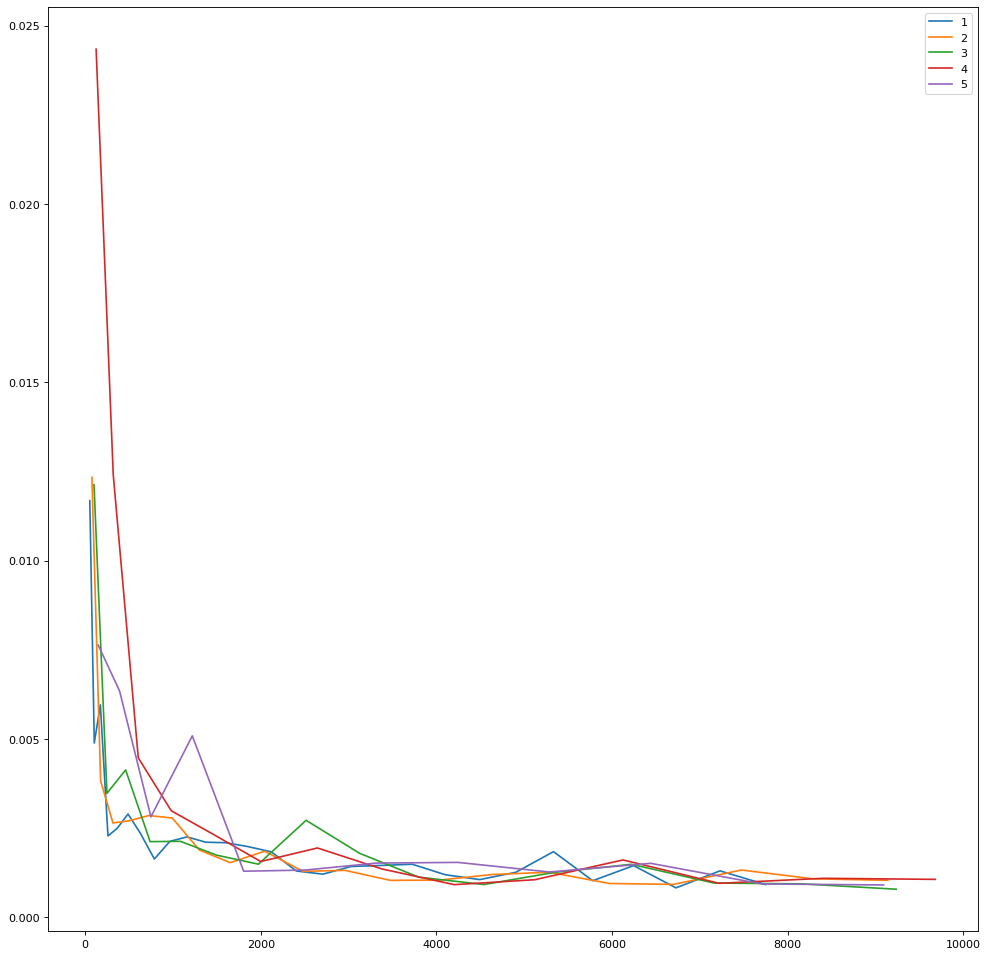

In [24]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

#### Transformer Blocks :

In [33]:
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, feature_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=feature_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="tanh"), layers.Dense(feature_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [34]:
def build(number_of_heads, feed_forward, number_of_blocks):

    feature_dim = 3 

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(None,3)))

    for i in range(number_of_blocks):

        model.add(TransformerBlock(feature_dim, number_of_heads, feed_forward))
  
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.add(tf.keras.layers.Flatten())

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

    return model

In [35]:
# Number of blocks 1-5
# Number of heads 1-128

NH = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 72, 80, ] # Number of heads in each block
NB = [i+1 for i in range(5)]# Number of blocks

In [36]:
Training_Results = []

C = 0

for number_of_heads in NH:
        
    for number_of_blocks in NB:
        MODEL = build(number_of_heads, 4, number_of_blocks)
        number_of_parameters = MODEL.count_params()
            
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
                
            MODEL.fit(X_train, normalized_y_train, epochs=100, validation_split=0.1, verbose=0, batch_size=64)
                
            end = time.time()
            
            y_pred_neural = convert_inverse(MODEL.predict(X_test))
            y_pred_train = convert_inverse(MODEL.predict(X_train))
                
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test,y_pred_neural)
                
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [number_of_heads, number_of_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, mse: %f, number of parameters : %d, time passed : %f" %(C, mse_test, number_of_parameters, end - start))

 1 -- Train results, mse: 0.019148, number of parameters : 140, time passed : 219.440937
 2 -- Train results, mse: 0.013065, number of parameters : 276, time passed : 400.488672
 3 -- Train results, mse: 0.015742, number of parameters : 412, time passed : 584.597993
 4 -- Train results, mse: 0.037244, number of parameters : 548, time passed : 768.719169
 5 -- Train results, mse: 0.013759, number of parameters : 684, time passed : 952.357288
 6 -- Train results, mse: 0.017707, number of parameters : 230, time passed : 290.567523
 7 -- Train results, mse: 0.011923, number of parameters : 456, time passed : 543.684851
 8 -- Train results, mse: 0.010709, number of parameters : 682, time passed : 798.179309
 9 -- Train results, mse: 0.021958, number of parameters : 908, time passed : 1054.895261
 10 -- Train results, mse: 0.010741, number of parameters : 1134, time passed : 1311.066746
 11 -- Train results, mse: 0.012746, number of parameters : 410, time passed : 432.470464
 12 -- Train res

 34 -- Train results, mse: 0.008830, number of parameters : 4508, time passed : 3865.469117
 35 -- Train results, mse: 0.015024, number of parameters : 5634, time passed : 4818.658606
 36 -- Train results, mse: 0.013377, number of parameters : 1310, time passed : 1132.369050
 37 -- Train results, mse: 0.069453, number of parameters : 2616, time passed : 2236.630881
 38 -- Train results, mse: 0.016405, number of parameters : 3922, time passed : 3333.353100
 39 -- Train results, mse: 0.007037, number of parameters : 5228, time passed : 4425.874471
 40 -- Train results, mse: 0.005531, number of parameters : 6534, time passed : 5519.979348
 41 -- Train results, mse: 0.012510, number of parameters : 1490, time passed : 1276.713898
 42 -- Train results, mse: 0.008207, number of parameters : 2976, time passed : 2522.644804
 43 -- Train results, mse: 0.013195, number of parameters : 4462, time passed : 3763.576190
 44 -- Train results, mse: 0.007014, number of parameters : 5948, time passed : 

 66 -- Train results, mse: 0.007189, number of parameters : 7162, time passed : 5926.817565
 67 -- Train results, mse: 0.007935, number of parameters : 9548, time passed : 7889.181637
 68 -- Train results, mse: 0.007090, number of parameters : 2570, time passed : 2150.119444
 69 -- Train results, mse: 0.007046, number of parameters : 5136, time passed : 4270.321788
 70 -- Train results, mse: 0.367577, number of parameters : 7702, time passed : 6369.300391
 71 -- Train results, mse: 0.011856, number of parameters : 2750, time passed : 2291.211323
 72 -- Train results, mse: 0.006669, number of parameters : 5496, time passed : 4551.258301
 73 -- Train results, mse: 0.008755, number of parameters : 8242, time passed : 6794.556907
 74 -- Train results, mse: 0.007544, number of parameters : 2930, time passed : 2440.913168
 75 -- Train results, mse: 0.007876, number of parameters : 5856, time passed : 4844.171687
 76 -- Train results, mse: 0.007672, number of parameters : 8782, time passed : 

In [37]:
with open("CNN_RNN_Transformers_Training_Results/Transformer_blocks_0_10000_TensorFlow.json", 'w') as f:
    json.dump(Training_Results, f)

In [38]:
f = open("CNN_RNN_Transformers_Training_Results/Transformer_blocks_0_10000_TensorFlow.json")
data = json.load(f)

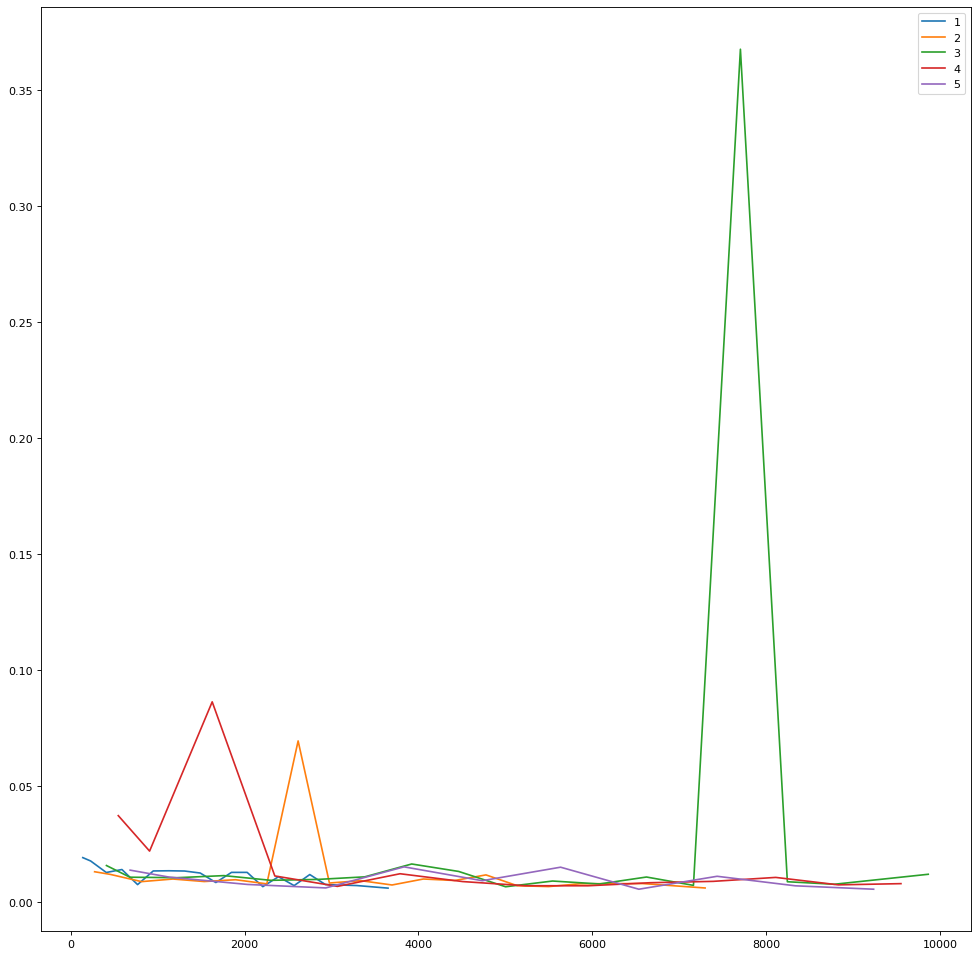

In [39]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()